In [1]:
# Text text processing library
import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import itertools as it
from models import *
from helpers import *
# import main
import matplotlib.pyplot as plt
import spacy
import time
import itertools as it
MAX_LEN = 20
MIN_FREQ = 5

In [2]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

BOS_WORD = '<s>'
EOS_WORD = '</s>'
DE = data.Field(tokenize=tokenize_de)

# only target needs BOS/EOS:
EN = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, eos_token = EOS_WORD) 

train, val, test = datasets.IWSLT.splits(exts=('.de', '.en'), fields=(DE, EN), 
                                         filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
                                         len(vars(x)['trg']) <= MAX_LEN)

In [3]:
DE.build_vocab(train.src, min_freq=MIN_FREQ)
EN.build_vocab(train.trg, min_freq=MIN_FREQ)

pred_set = []
for i, line in enumerate(open("source_test.txt"), 1):
    words = line.split()# [:-1]
    pred_set.append([DE.vocab.stoi[s] for s in words])

train_iter, val_iter, test_iter = data.BucketIterator.splits((train, val, test), batch_size=32, device=-1,
                                                  repeat=False, sort_key=lambda x: len(x.src))

In [17]:
batch = next(iter(test_iter))
# sent_inspect(batch,4)
def sent_inspect(batch, idx=0):
    print("Source")
    print(' '.join([DE.vocab.itos[w] for w in batch.src.data[:,idx]]))
    print("Target")
    print(' '.join([EN.vocab.itos[w] for w in batch.trg.data[:,idx]]))
# print(DE.vocab.stoi['<pad>'])

In [81]:
for i in range(10):
    print(' '.join(DE.vocab.itos[w] for w in debug_set[i]))
    print(' '.join(EN.vocab.itos[w] for w in debug_ans[i]))    

wo sich der Lauf des <unk> früher befand .
<s> We started to be able to see where the <unk> used to flow . </s> <pad> <pad>
Das führte mich dazu , Satellitenbilder zu benutzen .
<s> This is really what brought me to using satellite imagery . </s> <pad> <pad> <pad> <pad> <pad>
Wie unterscheidet sich diese Geschichte von der anderen ?
<s> How is this story different ? </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Im Raum war ein junger Mann , <unk> .
<s> One of the young men in the room was <unk> . </s> <pad> <pad> <pad> <pad> <pad>
Ich brachte rund 90 junge <unk> Führungskräfte zusammen .
<s> I brought together about 90 young Somali leaders . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Es vergeht vielleicht ein Jahr , aber nichts .
<s> Maybe a year passes , nothing . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Sein Dorf liegt in der Nähe von <unk> .
<s> His village is near <unk> . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Ich d

In [5]:
state_dict = torch.load('saved_models/attn_med_2.epoch_12.ckpt.tar')
for p in state_dict['model_encoder']:
    print(state_dict['model_encoder'][p].size())

torch.Size([13353, 500])
torch.Size([2000, 500])
torch.Size([2000, 500])
torch.Size([2000])
torch.Size([2000])
torch.Size([2000, 500])
torch.Size([2000, 500])
torch.Size([2000])
torch.Size([2000])
torch.Size([2000, 500])
torch.Size([2000, 500])
torch.Size([2000])
torch.Size([2000])
torch.Size([2000, 500])
torch.Size([2000, 500])
torch.Size([2000])
torch.Size([2000])


In [79]:
train_iter, val_iter = data.BucketIterator.splits((train, val), batch_size=32, device=-1,
                                                  repeat=False, sort_key=lambda x: len(x.src))
bs_encoder = BaseEncoder(DE, hidden_size=500, num_layers=4, word_features=500)
bs_decoder = BaseDecoder(EN, hidden_size=500, num_layers=4, word_features=500)
trainer = NMTTrainer([bs_encoder, bs_decoder], DE, EN, lrn_rate=0.7, 
                     lrn_decay='adaptive', reverse_enc_input=False)
evaluator = NMTEvaluator([bs_encoder, bs_decoder], DE, EN, reverse_enc_input=False)
trainer.train(train_iter, verbose=True, le=evaluator, val_iter=val_iter)

Target padding token: 1
Using CUDA...
Target padding token: 1
Using CUDA...
Epoch 0, loss: 75.106003, norm: 5.068851, elapsed: 601.591950, lrn_rate: 0.700000
Validation time: 1.177268 seconds
Validation set metric: 15.046797
Epoch 1, loss: 64.709015, norm: 6.823921, elapsed: 1202.462563, lrn_rate: 0.700000
Validation time: 1.123111 seconds
Validation set metric: 10.318951
Epoch 2, loss: 55.162987, norm: 5.810015, elapsed: 1815.646121, lrn_rate: 0.700000
Validation time: 1.158648 seconds
Validation set metric: 8.200983
Epoch 3, loss: 48.013638, norm: 6.298200, elapsed: 2430.358610, lrn_rate: 0.700000
Validation time: 1.222892 seconds
Validation set metric: 7.256750
Epoch 4, loss: 55.855797, norm: 8.171973, elapsed: 3034.166331, lrn_rate: 0.700000
Validation time: 1.161787 seconds
Validation set metric: 7.055706
Epoch 5, loss: 51.494362, norm: 9.309718, elapsed: 3637.575163, lrn_rate: 0.700000
Validation time: 1.184436 seconds
Validation set metric: 7.108363
Decaying LR to 0.350000
Epoch

KeyboardInterrupt: 

In [77]:
a = autograd.Variable(torch.Tensor([[1,1],[2,2]]))
b = torch.sum((a != 4).type(torch.FloatTensor)) / 3
print(b)

Variable containing:
 1.3333
[torch.FloatTensor of size 1]



In [41]:
bs_encoder = BaseEncoder(DE, hidden_size=650, num_layers=4, word_features=650, 
                         bidirectional=True, dropout=0.35)
# TODO: decide whether to add dropout to output states of encoder!
at_decoder = AttnDecoder(EN, hidden_size=650, num_layers=4, word_features=650, dropout=0.35,
                         tie_weights=True, enc_linear=650,
                         enc_bidirectional=True)
evaluator = NMTEvaluator([bs_encoder, at_decoder], DE, EN, attention=True,
                        record_attention=False, cuda=True)
evaluator.evaluate(test_iter)

Using final MLP
Target padding token: 1
Source padding token: 1
Using CUDA...


TypeError: torch.index_select received an invalid combination of arguments - got ([32;1mtorch.FloatTensor[0m, [32;1mint[0m, [31;1mtorch.cuda.LongTensor[0m), but expected (torch.FloatTensor source, int dim, torch.LongTensor index)

In [31]:
train_iter, val_iter = data.BucketIterator.splits((train, val), batch_size=32, device=-1,
                                                  repeat=False, sort_key=lambda x: len(x.src))
bs_encoder = BaseEncoder(DE, hidden_size=650, num_layers=4, word_features=650, 
                         bidirectional=True, dropout=0.35)
# TODO: decide whether to add dropout to output states of encoder!
at_decoder = AttnDecoder(EN, hidden_size=650, num_layers=4, word_features=650, dropout=0.35,
                         tie_weights=True, enc_linear=650,
                         enc_bidirectional=True)
trainer = NMTTrainer([bs_encoder, at_decoder], DE, EN, lrn_rate=1.2, 
                     lrn_decay='adaptive', attention=True,
                     clip_norm=5, lrn_decay_force=8, cuda=True)
evaluator = NMTEvaluator([bs_encoder, at_decoder], DE, EN, attention=True,
                        record_attention=False, cuda=True)
trainer.train(train_iter, verbose=True, le=evaluator, val_iter=val_iter,
              save_model_fn='attn_med_5', num_iter=20)
# KEYXX

Using final MLP
Target padding token: 1
Source padding token: 1
Using CUDA...
Target padding token: 1
Source padding token: 1
Using CUDA...
Innitializing parameters status:  True
Epoch 0, loss: 46.713978, norm: 5.329768, elapsed: 1063.894383, lrn_rate: 1.200000
Validation time: 1.941442 seconds
Validation set metric: 10.928670
Saving model to saved_models/attn_med_5.epoch_0.ckpt.tar
Epoch 1, loss: 42.267780, norm: 7.347247, elapsed: 2163.232243, lrn_rate: 1.200000
Validation time: 1.904391 seconds
Validation set metric: 6.930205
Saving model to saved_models/attn_med_5.epoch_1.ckpt.tar
Epoch 2, loss: 36.884426, norm: 7.626665, elapsed: 3208.078403, lrn_rate: 1.200000
Validation time: 1.817674 seconds
Validation set metric: 5.795428
Saving model to saved_models/attn_med_5.epoch_2.ckpt.tar
Epoch 3, loss: 31.893240, norm: 6.090264, elapsed: 4255.479510, lrn_rate: 1.200000
Validation time: 1.843599 seconds
Validation set metric: 5.251451
Saving model to saved_models/attn_med_5.epoch_3.ckpt.

4.338333858249031

In [ ]:
cnt = 0
for hs, tw, force, drop in it.product([200,400,600],[False, True],
                                      [4,8],[0.2, 0.4]):
    print(hs, tw, force, drop)
    train_iter, val_iter = data.BucketIterator.splits((train, val), batch_size=32, device=-1,
                                                      repeat=False, sort_key=lambda x: len(x.src))
    bs_encoder = BaseEncoder(DE, hidden_size=hs, num_layers=4, word_features=hs, 
                             dropout=drop)
    # TODO: decide whether to add dropout to output states of encoder!
    at_decoder = AttnDecoder(EN, hidden_size=hs, num_layers=4, word_features=hs, dropout=drop,
                             tie_weights=tw)
    trainer = NMTTrainer([bs_encoder, at_decoder], DE, EN, lrn_rate=1.0, 
                         lrn_decay='adaptive', attention=True,
                         clip_norm=5, lrn_decay_force=force)
    evaluator = NMTEvaluator([bs_encoder, at_decoder], DE, EN, attention=True,
                            record_attention=False)
    trainer.train(train_iter, verbose=True, le=evaluator, val_iter=val_iter,
                  save_model_fn='attn_grid_%d' % cnt, num_iter=10)
    cnt += 1

200 False 4 0.2
Target padding token: 1
Using CUDA...
Target padding token: 1
Using CUDA...
Innitializing parameters status:  True
Epoch 0, loss: 83.561142, norm: 4.071474, elapsed: 271.279075, lrn_rate: 1.000000
Validation time: 0.360532 seconds
Validation set metric: 22.966567
Saving model to saved_models/attn_grid_0.epoch_0.ckpt.tar
Epoch 1, loss: 82.306152, norm: 4.954175, elapsed: 548.610403, lrn_rate: 1.000000
Validation time: 0.354557 seconds
Validation set metric: 15.265598
Saving model to saved_models/attn_grid_0.epoch_1.ckpt.tar
Epoch 2, loss: 59.941078, norm: 4.696200, elapsed: 828.961941, lrn_rate: 1.000000
Validation time: 0.392126 seconds
Validation set metric: 9.756422
Saving model to saved_models/attn_grid_0.epoch_2.ckpt.tar
Epoch 3, loss: 55.912140, norm: 5.782441, elapsed: 1111.078448, lrn_rate: 1.000000
Validation time: 0.360725 seconds
Validation set metric: 7.972600
Saving model to saved_models/attn_grid_0.epoch_3.ckpt.tar
Decaying LR to 0.500000
Epoch 4, loss: 54.

Epoch 5, loss: 52.777771, norm: 5.691047, elapsed: 1657.517624, lrn_rate: 1.000000
Validation time: 0.355772 seconds
Validation set metric: 7.938821
Saving model to saved_models/attn_grid_3.epoch_5.ckpt.tar
Epoch 6, loss: 61.794411, norm: 6.426108, elapsed: 1936.887601, lrn_rate: 1.000000
Validation time: 0.348664 seconds
Validation set metric: 7.579755
Saving model to saved_models/attn_grid_3.epoch_6.ckpt.tar
Epoch 7, loss: 58.316906, norm: 5.636143, elapsed: 2217.693143, lrn_rate: 1.000000
Validation time: 0.371190 seconds
Validation set metric: 7.299893
Saving model to saved_models/attn_grid_3.epoch_7.ckpt.tar
Decaying LR to 0.500000
Epoch 8, loss: 51.196472, norm: 5.013029, elapsed: 2497.512262, lrn_rate: 0.500000
Validation time: 0.349605 seconds
Validation set metric: 6.763396
Saving model to saved_models/attn_grid_3.epoch_8.ckpt.tar
Decaying LR to 0.250000
Epoch 9, loss: 47.804970, norm: 5.102167, elapsed: 2778.161504, lrn_rate: 0.250000
Validation time: 0.367842 seconds
Validat

Epoch 0, loss: 80.696709, norm: 4.487724, elapsed: 268.828376, lrn_rate: 1.000000
Validation time: 0.356540 seconds
Validation set metric: 19.476453
Saving model to saved_models/attn_grid_7.epoch_0.ckpt.tar
Epoch 1, loss: 84.230835, norm: 5.347474, elapsed: 540.498028, lrn_rate: 1.000000
Validation time: 0.353929 seconds
Validation set metric: 14.954864
Saving model to saved_models/attn_grid_7.epoch_1.ckpt.tar
Epoch 2, loss: 64.211594, norm: 4.860816, elapsed: 813.037319, lrn_rate: 1.000000
Validation time: 0.354883 seconds
Validation set metric: 11.287956
Saving model to saved_models/attn_grid_7.epoch_2.ckpt.tar
Epoch 3, loss: 60.588867, norm: 6.156037, elapsed: 1087.799996, lrn_rate: 1.000000
Validation time: 0.348687 seconds
Validation set metric: 9.001583
Saving model to saved_models/attn_grid_7.epoch_3.ckpt.tar
Epoch 4, loss: 62.230396, norm: 5.461389, elapsed: 1363.474364, lrn_rate: 1.000000
Validation time: 0.371995 seconds
Validation set metric: 8.228699
Saving model to saved_m

In [5]:
# Load a model and continue training:
ld_enc, ld_dec = load_checkpoint('saved_models/attn_med_1.epoch_8.ckpt.tar')
ld_encoder = BaseEncoder(DE, hidden_size=400, num_layers=4, word_features=400, 
                         dropout=0.2)
ld_decoder = AttnDecoder(EN, hidden_size=400, num_layers=4, word_features=400, 
                         dropout=0.2)
set_parameters(ld_encoder, ld_enc)
set_parameters(ld_decoder, ld_dec)
evaluator = NMTEvaluator([ld_encoder, ld_decoder], DE, EN, attention=True,
                        record_attention=False)
print(evaluator.evaluate(val_iter))
trainer = NMTTrainer([ld_encoder, ld_decoder], DE, EN, lrn_rate=0.5, 
                     lrn_decay='adaptive', attention=True,
                     clip_norm=5, lrn_decay_force=2)
trainer.train(train_iter, verbose=True, le=evaluator, val_iter=val_iter,
              save_model_fn='attn_med_1b', init_parameters=False)

Target padding token: 1
Using CUDA...
Validation time: 0.677992 seconds
5.322171705651731
Target padding token: 1
Using CUDA...
Innitializing parameters status:  False
Epoch 0, loss: 39.508476, norm: 6.285943, elapsed: 426.947739, lrn_rate: 0.500000
Validation time: 0.728775 seconds
Validation set metric: 5.209565
Saving model to saved_models/attn_med_1b.epoch_0.ckpt.tar
Epoch 1, loss: 44.648376, norm: 7.371956, elapsed: 859.301896, lrn_rate: 0.500000
Validation time: 0.614820 seconds
Validation set metric: 5.190459
Saving model to saved_models/attn_med_1b.epoch_1.ckpt.tar
Decaying LR to 0.250000
Epoch 2, loss: 38.062698, norm: 7.248244, elapsed: 1291.240771, lrn_rate: 0.250000
Validation time: 0.749838 seconds
Validation set metric: 5.085312
Saving model to saved_models/attn_med_1b.epoch_2.ckpt.tar
Decaying LR to 0.125000
Epoch 3, loss: 32.695580, norm: 6.297701, elapsed: 1722.055861, lrn_rate: 0.125000
Validation time: 0.788171 seconds
Validation set metric: 5.076100
Saving model to 

KeyboardInterrupt: 

In [6]:
print(evaluator.evaluate(val_iter))
print(evaluator.evaluate(test_iter))

Validation time: 0.659822 seconds
5.120132318658038
Validation time: 0.872873 seconds
6.3874894806368365


In [39]:
print(evaluator.evaluate(val_iter))
print(len(train_iter))
print(evaluator.attns_log[0][4])
val_iter.init_epoch()
batch = next(iter(val_iter))
sent_inspect(batch, 4)

Validation time: 0.456792 seconds
6.048956472651303
3722
Variable containing:
 0.6505  0.1110  0.0659  0.1725
 0.5297  0.1554  0.2806  0.0343
 0.0089  0.4239  0.4734  0.0938
 0.0180  0.0371  0.9122  0.0327
 0.0822  0.0702  0.3141  0.5335
 0.4222  0.2591  0.0997  0.2190
 0.1612  0.3041  0.4915  0.0432
 0.2962  0.4637  0.0781  0.1620
[torch.cuda.FloatTensor of size 8x4 (GPU 0)]

Source
Ich hatte Angst –
Target
<s> And I was scared . </s> <pad> <pad>


In [4]:
# save_checkpoint(bs_encoder, at_decoder, filename='saved_models/attn_big_0.epoch_10.ckpt.tar')
def load_validate_model(fn):
    ld_enc, ld_dec = load_checkpoint(fn)
    ld_encoder = BaseEncoder(DE, hidden_size=650, num_layers=4, word_features=650, 
                             bidirectional=True, dropout=0.35)
    ld_decoder = AttnDecoder(EN, hidden_size=650, num_layers=4, word_features=650, dropout=0.35,
                             tie_weights=False, enc_linear=650,
                             enc_bidirectional=True)
    set_parameters(ld_encoder, ld_enc)
    set_parameters(ld_decoder, ld_dec)
    evaluator = NMTEvaluator([ld_encoder, ld_decoder], DE, EN, attention=True,
                            record_attention=True)
    print(evaluator.evaluate(val_iter))
    return evaluator
evaluator=load_validate_model('saved_models/attn_med_5.epoch_10.ckpt.tar')
# print(evaluator.evaluate(test_iter)) # KEYYY
# evaluator.predict(pred_set, fn='predictions_big_2_100.txt',beam_size=200, ignore_eos=True)

Using final MLP
Target padding token: 1
Source padding token: 1
Using CUDA...
Validation time: 2.021641 seconds
4.293765398892552


5


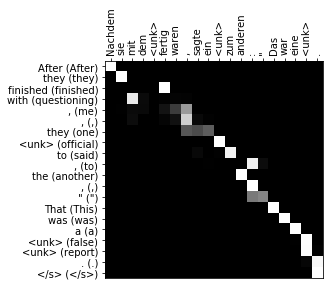

In [5]:
# for ep in [0,1,2,6,10]:
#     evaluator = load_validate_model('saved_models/attn_med_5.epoch_%d.ckpt.tar' % ep)
#     attn_list = list(evaluator.attns_log[10][i][1] for i in range(4))
#     evaluator.visualize_attn(*attn_list)
#     plt.savefig('attn_plots/learning_%d.pdf' % ep)
attn_list = list(evaluator.attns_log[17][i][1] for i in range(4))
attn_list.append('attn_plots/attn_vis_1.png')
print(len(attn_list))
evaluator.visualize_attn(*attn_list)
# plt.savefig('attn_plots/attn_vis_1.png')

In [11]:
test_iter.init_epoch()
debug_iter = iter(test_iter)
for i in range(10):
    batch = next(debug_iter)
debug_set = [batch.src.data[:, i] for i in range(batch.src.data.size(1))]
debug_ans = [batch.trg.data[:, i] for i in range(batch.trg.data.size(1))]
evaluator.predict(pred_set, fn='predictions_real.txt',beam_size=200)

In [68]:
print(evaluator.evaluate(val_iter))
print(evaluator.evaluate(test_iter))

Validation time: 1.352269 seconds
4.868429206982359
Validation time: 1.816732 seconds
6.052567905074193


In [10]:
a = torch.Tensor([-np.inf])
print(a)


-inf
[torch.FloatTensor of size 1]



In [20]:
# Class that NMT{Trainer/Evaluator} extends
class NMTModelUser(object):
    # Models is a list [Encoder, Decoder]
    def __init__(self, models, TEXT_SRC, TEXT_TRG, mask_src=False,
                 attention=False, reverse_enc_input=False, cuda=True):
        self._TEXT_SRC = TEXT_SRC
        self._TEXT_TRG = TEXT_TRG
        self.trg_pad = TEXT_TRG.vocab.stoi['<pad>']
        self.src_pad = TEXT_SRC.vocab.stoi['<pad>']
        print('Target padding token: %d' % self.trg_pad)
        print('Source padding token: %d' % self.src_pad)
        self.models = models
        self.mask_src = mask_src
        self.use_attention = attention
        self.record_attention = False
        self.reverse_enc_input = reverse_enc_input
        self.cuda = cuda and torch.cuda.is_available()
        if self.cuda:
            print('Using CUDA...')
        else:
            print('CUDA is unavailable...')

    def get_src_and_trg(self, batch):
        if self.reverse_enc_input:
            src_data = torch.t(batch.src.data)
            ind_rev = torch.LongTensor(np.arange(src_data.size(1) - 1, -1, -1))
            src = torch.index_select(torch.t(batch.src.data), dim=1,
                                     index=ind_rev)
            src = src.contiguous()
        else:
            src = torch.t(batch.src.data).contiguous()
        trg = torch.t(batch.trg.data)
        # Have to shift the target so we don't predict the word 
        # we see (this is ok since sentences in trg all begin 
        # with <s>)
        trg_feat = trg[:, :-1].contiguous()
        trg_lab = trg[:, 1:].contiguous()
        return (src, trg_feat, trg_lab)

    def zeros_hidden(self, batch_sz, model_num):
        num_directions = 2 if self.models[model_num].bidirectional else 1
        return torch.zeros(self.models[model_num].num_layers * num_directions, 
                           batch_sz,
                           self.models[model_num].hidden_size)

    # Ok to have self.prev_hidden apply to encoder then decoder since
    # encoder all ends before decoder starts
    def prepare_hidden(self, batch_sz, zero_out=True, model_num=0):
        if (not self.prev_hidden is None) and (not zero_out):
            pre_hidden = self.prev_hidden
        else:
            pre_hidden = (self.zeros_hidden(batch_sz, model_num) \
                          for i in range(2))
        if self.cuda:
            pre_hidden = tuple(t.cuda() for t in pre_hidden)
        return tuple(autograd.Variable(t) for t in pre_hidden)

    # kwargs can contain zero_out, model_num for prepare_hidden
    def prepare_model_inputs(self, batch, **kwargs):
        if self.cuda:
            src, trg_feat, trg_lab = \
                tuple(t.cuda() for t in self.get_src_and_trg(batch))
        else:
            src, trg_feat, trg_lab = self.get_src_and_trg(batch)

        # TODO: can comment this out (assuming it passes
        # -- just is checking batch-sz)
        assert batch.src.size(1) == batch.trg.size(1)
        var_hidden = self.prepare_hidden(batch.src.size(1), **kwargs)

        var_src = autograd.Variable(src)
        var_trg_feat = autograd.Variable(trg_feat)
        var_trg_lab = autograd.Variable(trg_lab)

        return (var_src, var_trg_feat, var_trg_lab, var_hidden)

    def init_epoch(self):
        self.prev_hidden = None
        self.debug_cnt = 0
        
    def debug_model_output(self, var_src, var_trg, dec_output,
                           num_samp=10):
        print('DEBUG CNT: %d' % self.debug_cnt)
        print(var_src.size(), var_trg.size(), dec_output.size())
        self.debug_cnt += 1
        if self.debug_cnt > 10:
            return
        src = var_src.data
        trg = var_trg.data
        _, pred = torch.topk(dec_output, k=1, dim=2)
        pred = pred.squeeze().data
        print(pred.size()) # should be [batch_sz, sent_len]
        for i in range(num_samp):
            print('=== SAMPLE %d ===' % i)
            print('-- SRC --')
            print(' '.join(self._TEXT_SRC.vocab.itos[src[i,j]] \
                                           for j in range(src.size(1))))
            print('-- REAL TRG --')
            print(' '.join(self._TEXT_TRG.vocab.itos[trg[i,j]] \
                                           for j in range(trg.size(1))))
            print('-- PRED TRG --')
            print(' '.join(self._TEXT_TRG.vocab.itos[pred[i,j]] \
                                           for j in range(pred.size(1))))


    def set_enc_prev_hidden(self, enc_hidden):
        # Each element of hidden is [F(x_T), B(x_1)]; we want to use
        # the first
        if self.models[1].enc_directions == 2:
            assert self.use_attention
            # This is the first hidden B(x_1) of the backwards layer
            self.prev_hidden = tuple(h[self.models[0].num_layers:,:,:] for \
                                     h in enc_hidden)
        else:
            self.prev_hidden = enc_hidden

    def generate_attn_mask(self, var_src):
        if not self.mask_src:
            return None
        # Using broadcasting 
        pad_mask = torch.eq(var_src, self.src_pad).type(torch.FloatTensor)
        pad_mask = pad_mask.cuda() if self.cuda else pad_mask
        return pad_mask
        
    def run_model(self, batch, mode='mean'):
        # var_src, var_trg are [batch_sz, sent_len]
        var_src, var_trg_feat, var_trg_lab, var_hidden = \
            self.prepare_model_inputs(
            batch, zero_out=True, model_num=0)

        # For attention, will use enc_output (not otherwise)
        enc_output, enc_hidden = self.models[0](var_src, var_hidden)
        self.set_enc_prev_hidden(enc_hidden)
            
        if self.use_attention:
            pad_mask = self.generate_attn_mask(var_src)
            dec_output, dec_hidden, dec_attn = self.models[1](
                var_trg_feat, self.prev_hidden, enc_output, pad_mask)
            if self.record_attention:
                _, pred = torch.topk(dec_output, k=1, dim=2)
                self.attns_log.append((dec_attn, var_src, pred.squeeze(),
                                       var_trg_lab))
        else:
            # Using real words as input. Use prev_hidden both to
            # initialize hidden state (the first time) and as context
            # vector
            dec_output, dec_hidden = self.models[1](
                var_trg_feat, self.prev_hidden, enc_hidden)
            
        # TEMPORARY
        # self.debug_model_output(var_src, var_trg_lab, dec_output)
        self.prev_hidden = dec_hidden
        loss = self.nll_loss(dec_output, var_trg_lab, mode=mode)
        return loss

    # Assume log_probs is [batch_sz, sent_len, V], output is
    # [batch_sz, sent_len]
    def nll_loss(self, log_probs, output, mode='mean', **kwargs):
        batch_sz = log_probs.size(0)
        sl_type = torch.cuda.FloatTensor if self.cuda else \
            torch.FloatTensor
        sent_len = torch.sum((output != self.trg_pad).type(sl_type)) / batch_sz
        # sent_len = sent_len.data[0]
        # sent_len = log_probs.size(1)
        # print(sent_len, log_probs.size())
        log_probs_rshp = log_probs.view(-1, log_probs.size(2))
        output_rshp = output.view(-1)
        if mode == 'mean':
            # Sum over all words in sent, mean over sentences; 
            # make sure to ignore padding
            return F.nll_loss(log_probs_rshp, output_rshp, 
                              ignore_index=self.trg_pad, 
                              **kwargs) * sent_len
        elif mode == 'sum':
            # Sum over all sentences and words in them
            return F.nll_loss(log_probs_rshp, output_rshp,
                              ignore_index=self.trg_pad,
                              size_average=False)
        else:
            raise ValueError('Invalid mode field: %s' % mode)
            
class NMTEvaluator(NMTModelUser):
    def __init__(self, models, TEXT_SRC, TEXT_TRG, record_attention=False,
                 visualize_freq=None, **kwargs):
        super(NMTEvaluator, self).__init__(models, TEXT_SRC, TEXT_TRG,
                                           **kwargs)
        # Perhaps overwrite record_attention
        self.record_attention = record_attention
        self.visualize_freq = visualize_freq
        
    def init_epoch(self):
        super(NMTEvaluator, self).init_epoch()
        self.attns_log = list()
        
    def visualize_attn(self, dec_attn_smpl, var_src_smpl, pred_smpl,
                       var_trg_lab=None, save_fn=None):
        # dec_attn_smpl is [src_len, pred_len], var_src_smpl is [src_len],
        # pred_smpl is [pred_len]
        attn = dec_attn_smpl.cpu().data.numpy()
        src_words = np.array(list(map(lambda x: self._TEXT_SRC.vocab.itos[x], 
                                      var_src_smpl.cpu().data.numpy())))
        pred_words = np.array(list(map(lambda x: self._TEXT_TRG.vocab.itos[x], 
                                       pred_smpl.cpu().data.numpy())))
        if not var_trg_lab is None:
            trg_cpu = var_trg_lab.cpu().data.numpy()
            trg_words = np.array(list(map(lambda x : self._TEXT_TRG.vocab.itos[x],
                                         trg_cpu)))
            pred_words = np.array(['%s (%s)' % (pred_words[i], trg_words[i]) for \
                                   i in range(pred_words.shape[0])])
            pad_idx = np.where(trg_words == '<pad>')[0]
            if len(pad_idx):
                clip_len = pad_idx[0]
                trg_words = trg_words[:clip_len]
                pred_words = pred_words[:clip_len]
                attn = attn[:clip_len, :]
        
        fig, ax = plt.subplots()
        ax.imshow(attn, cmap='gray')
        plt.xticks(range(len(src_words)),src_words, rotation='vertical')
        plt.yticks(range(len(pred_words)),pred_words)
        ax.xaxis.tick_top()
        if not save_fn is None:
            plt.savefig(save_fn)
        plt.show()

    def evaluate(self, test_iter, num_iter=None):
        start_time = time.time()
        for model in self.models:
            model.eval()
        nll_sum = 0
        nll_cnt = 0

        self.init_epoch()
        test_iter.init_epoch()
        for i,batch in enumerate(test_iter):
            nll_cnt += batch.trg.data.numel()
            loss = self.run_model(batch, mode='sum')
            # TODO: make sure loss just has 1 element!
            nll_sum += loss.data[0]
            
            if self.visualize_freq and i % self.visualize_freq == 0:
                sample = self.attns_log[-1]
                self.visualize_attn(sample[0][0], sample[1][0], sample[2][0])
            if not num_iter is None and i > num_iter:
                break
                        
        # Wrap the model.eval(), just in case
        for model in self.models:
            model.train()
        
        print('Validation time: %f seconds' % (time.time() - start_time))
        return np.exp(nll_sum / nll_cnt)
    
    # Performs beam search
    def run_model_predict(self, sent, ref_beam, ref_voc,
                          beam_size=100, pred_len=3, pred_num=None,
                          ignore_eos=False, translate_mode=False):
        if pred_num is None:
            pred_num = beam_size
        
        # [sent_len]
        sent_tsr = torch.LongTensor(sent)
        if self.reverse_enc_input:
            ind_rev = torch.LongTensor(np.arange(sent_tsr.size(0) - 1, -1, -1))
            sent_tsr = torch.index_select(sent_tsr, dim=0,
                                          index=ind_rev)
        if self.cuda:
            sent_tsr = sent_tsr.cuda()
        var_src = autograd.Variable(sent_tsr.view(1, -1).expand(beam_size, -1))
        var_hidden = self.prepare_hidden(beam_size, zero_out=True)
        
        # For attention, will use enc_output (not otherwise)
        enc_output, enc_hidden = self.models[0](var_src, var_hidden)
        self.set_enc_prev_hidden(enc_hidden)
        
        # Make sure to start with SOS token
        sos_token = self._TEXT_TRG.vocab.stoi['<s>']
        self.cur_beams = (sos_token * torch.ones(beam_size, 1)).type(torch.LongTensor)
        self.cur_beam_vals = torch.zeros(beam_size, 1).type(torch.FloatTensor)
        if self.cuda:
            self.cur_beams = self.cur_beams.cuda()
            self.cur_beam_vals = self.cur_beam_vals.cuda()
        self.cur_beams = autograd.Variable(self.cur_beams)
        self.cur_beam_vals = autograd.Variable(self.cur_beam_vals)

        if translate_mode:
            final_preds = list()

        for i in range(pred_len):
            if translate_mode:
                (ref_beam, ref_voc) = self.create_beam_arrays(self.cur_beams.size(0))

            cur_sent = self.cur_beams[:, i:i+1]
            if self.use_attention:
                pad_mask = self.generate_attn_mask(var_src)

                dec_output, dec_hidden, dec_attn = self.models[1](
                    cur_sent, self.prev_hidden, enc_output, pad_mask)
                if self.record_attention:
                    _, pred = torch.topk(dec_output, k=1, dim=2)
                    self.attns_log.append((dec_attn, var_src, pred.squeeze(),
                                           None))
            else:
                # Using real words as input. Use prev_hidden both to
                # initialize hidden state (the first time) and as context
                # vector
                dec_output, dec_hidden = self.models[1](
                    cur_sent, self.prev_hidden, enc_hidden)
            self.prev_hidden = dec_hidden
            
            # dec_output is [batch_sz, sent_len=1, V]
            # print(dec_output.size())
            # Using broadcasting:
            dec_output = dec_output.squeeze()

            # Deal with EOS tokens:
            if ignore_eos:
                eos_token = self._TEXT_TRG.vocab.stoi['</s>']
                dec_output[:, eos_token] = -np.inf

            dec_output = dec_output + self.cur_beam_vals
            if i == 0:
                # All start words were the same, so need to restrict 
                # to the first row
                dec_output = dec_output[0, :]
            else:
                dec_output = dec_output.view(-1)
                
            topk_dec, topk_inds = torch.topk(dec_output, k=beam_size)
            chosen_prev_inds = torch.index_select(ref_beam, dim=0, index=topk_inds)
            chosen_prevs = torch.index_select(self.cur_beams, dim=0,
                                              index=chosen_prev_inds)
            # Important to update hidden to reflect which prev 
            # sents we choose
            self.prev_hidden = tuple(torch.index_select(
                    self.prev_hidden[j], dim=1, index=chosen_prev_inds) \
                                     for j in range(len(self.prev_hidden)))
            
            # Update self.cur_beam_vals: [beam_sz, 1] 
            # (we already added on prev cur_beam_vals above)
            self.cur_beam_vals = topk_dec.view(-1, 1)
            # print('cur_beam_vals', self.cur_beam_vals)

            # [batch_sz=beam_sz, 1]
            chosen_nexts = torch.index_select(ref_voc, dim=0, index=topk_inds).view(-1, 1)
            # print('chosen_nexts', chosen_nexts)
            self.cur_beams = torch.cat((chosen_prevs, chosen_nexts), dim=1)

            # Hugely inefficient, but whatever
            if translate_mode:
                keep_sents = list()
                eos_token = self._TEXT_TRG.vocab.stoi['</s>']
                for i in self.cur_beams.size(0):
                    if self.cur_beams[i,-1].data[0] == eos_token:
                        final_preds.append(self.cur_beams[i,:])
                    else:
                        keep_sents.append(i)
                    keep_idx = autograd.Variable(torch.LongTensor(keep_sents))
                    keep_idx = keep_idx.cuda() if self.cuda else keep_idx

                    # Now reselect
                    self.cur_beams = torch.index_select(self.cur_beams, 0,
                                                        keep_idx)
                    self.cur_beam_vals = torch.index_select(self.cur_beam_vals, 0,
                                                            keep_idx)
                    self.prev_hidden = tuple(torch.index_select(
                        self.prev_hidden[j], 1, keep_idx) \
                                             for j in range(len(self.prev_hidden)))
                    print(self.cur_beams)
                    print(self.cur_beam_vals)
                    print(self.prev_hidden[0].size())

                if len(keep_sents) > 100:
                    return keep_sents
            # print('cur_beams', self.cur_beams)

        if translate_mode:
            return keep_sents, self.cur_beams
        return self.cur_beams
    
    @staticmethod
    def escape(l):
        return l.replace("\"", "<quote>").replace(",", "<comma>")

    def create_ref_arrays(self, beam_size):
        # Create reference idx for expanding beams and vocab
        trg_vocab_sz = len(self._TEXT_TRG.vocab)
        ref_beam = torch.LongTensor(np.arange(beam_size)).view(-1, 1).expand(-1, trg_vocab_sz)
        ref_beam = ref_beam.contiguous().view(-1)
        ref_beam = ref_beam.cuda() if self.cuda else ref_beam
        ref_beam = autograd.Variable(ref_beam)
        
        ref_voc = torch.LongTensor(np.arange(trg_vocab_sz)).view(1, -1).expand(beam_size, -1)
        ref_voc = ref_voc.contiguous().view(-1)
        ref_voc = ref_voc.cuda() if self.cuda else ref_voc
        ref_voc = autograd.Variable(ref_voc)
        return (ref_beam, ref_voc)
        
    def predict(self, test_set, fn='predictions.txt', num_cands=100, pred_len=3,
                beam_size=100, ignore_eos=False, translate_mode=False):
        start_time = time.time()
        for model in self.models:
            model.eval()

        (ref_beam, ref_voc) = self.create_ref_arrays(beam_size)
            
        self.init_epoch()
        predictions = list()
        for i,sent in enumerate(test_set):
            # [pred_num, pred_len] tensor
            best_translations = self.run_model_predict(sent, ref_beam=ref_beam,
                                                       ref_voc=ref_voc,
                                                       pred_len=pred_len,
                                                       beam_size=beam_size,
                                                       ignore_eos=ignore_eos,
                                                       translate_mode=translate_mode)
            predictions.append(best_translations)
            # if i > 10:
            #     break
            
        print('Writing predictions to %s...' % fn)
        with open(fn, 'w') as fout:
            print('id,word', file=fout)
            for i,preds in enumerate(predictions):
                # We can traverse the beam in order since topk 
                # sorts its output
                cands = list()
                for j in range(num_cands):
                    # Ignore SOS
                    words = [self._TEXT_TRG.vocab.itos[preds[j,k].data[0]] for k in range(1, pred_len + 1)]
                    sent = '|'.join(self.escape(l) for l in words)
                    cands.append(sent)
                print('%d,%s' % (i+1, ' '.join(cands)), file=fout)
        print('Computing predictions took %f seconds' % (time.time() - start_time))
        
        # Wrap model.eavl
        for model in self.models:
            model.train()
            

    
class NMTTrainer(NMTModelUser):
    def __init__(self, models, TEXT_SRC, TEXT_TRG, lrn_rate=0.1,
                 optimizer=optim.SGD, lrn_decay='none',
                 lrn_decay_force=np.inf,
                 lrn_decay_rate=0.1,
                 clip_norm=10, **kwargs):
        super(NMTTrainer, self).__init__(models, TEXT_SRC, TEXT_TRG, **kwargs)

        self.base_lrn_rate = lrn_rate
        self.optimizer_type = optimizer
        self.init_optimizers()

        # Do learning rate decay:
        self.lr_decay_opt = lrn_decay
        self.lr_decay_force = lrn_decay_force
        if self.lr_decay_opt == 'none' or self.lr_decay_opt == 'adaptive':
            self.lambda_lr = lambda i : 1
        elif self.lr_decay_opt == 'invlin':
            decay_rate = lrn_decay_rate
            self.lambda_lr = lambda i : 1 / (1 + (i-6) * decay_rate) if i > 6 else 1
        else:
            raise ValueError('Invalid learning rate decay option: %s' \
                             % self.lr_decay_opt)
        self.schedulers = [optim.lr_scheduler.LambdaLR(optimizer,
            self.lambda_lr) for optimizer in self.optimizers]

        self.clip_norm = clip_norm
        self.init_lists()
        if self.cuda:
            for model in self.models:
                model.cuda()
                
    def init_optimizers(self):
        self.optimizers = [self.optimizer_type(filter(lambda p : p.requires_grad,
                                                      model.parameters()),
                                               lr = self.base_lrn_rate) for \
                           model in self.models]
    def init_lists(self):
        self.training_losses = list()
        self.training_norms = list()
        self.val_perfs = list()

    def get_loss_data(self, loss):
        if self.cuda:
            return loss.data.cpu().numpy()[0]
        else:
            return loss.data.numpy()[0]

    def make_recordings(self, loss, norm):
        self.training_norms.append(norm)
        self.training_losses.append(loss)

    def clip_norms(self):
        # Clip grad norm after backward but before step
        if self.clip_norm > 0:
            parameters = tuple()
            for model in self.models:
                parameters += tuple(model.parameters())
                
            # Norm clipping: returns a float
            norm = nn.utils.clip_grad_norm(
                parameters, self.clip_norm)
        else:
            norm = -1
        return norm

    def train_batch(self, batch, **kwargs):
        for model in self.models:
            model.zero_grad()
            
        loss = self.run_model(batch)
        loss.backward()

        # norms must be clipped after backward but before step
        norm = self.clip_norms()

        loss_data = self.get_loss_data(loss)
        # print('TEMP: ', loss_data, norm)
        if kwargs.get('verbose', False):
            self.make_recordings(loss_data, norm)

        for optimizer in self.optimizers:
            optimizer.step()

        # Return loss and norm (before gradient step)
        return loss_data, norm

    def init_parameters(self):
        for model in self.models:
            for p in model.parameters():
                p.data.uniform_(-0.05, 0.05)

    def train(self, torch_train_iter, le=None, val_iter=None,
              save_model_fn=None, init_parameters=True, **kwargs):
        self.init_lists()
        start_time = time.time()
        print("Innitializing parameters status: ", init_parameters)
        if init_parameters:
            self.init_parameters()

        torch_train_iter.init_epoch()
        for epoch in range(kwargs.get('num_iter', 100)):
            self.init_epoch()
            for model in self.models:
                model.train()
                
            # Learning rate decay, if any
            if self.lr_decay_opt == 'adaptive':
                if (epoch > 2 and self.val_perfs[-1] > self.val_perfs[-2]) or \
                   (epoch >= self.lr_decay_force):
                    self.base_lrn_rate = self.base_lrn_rate / 2
                    self.init_optimizers() # Looks at self.base_lrn_rate
                    print('Decaying LR to %f' % self.base_lrn_rate)
            else:
                for scheduler in self.schedulers:
                    scheduler.step()

            # TODO: LR decay
            train_iter = iter(torch_train_iter)

            for batch in train_iter:
                res_loss, res_norm = self.train_batch(batch, **kwargs)

            if epoch % kwargs.get('skip_iter', 1) == 0:
                if not kwargs.get('verbose', False):
                    self.make_recordings(res_loss, res_norm)

            print('Epoch %d, loss: %f, norm: %f, elapsed: %f, lrn_rate: %f' \
                  % (epoch, np.mean(self.training_losses[-10:]),
                     np.mean(self.training_norms[-10:]),
                     time.time() - start_time,
                     self.base_lrn_rate)) #  * self.lambda_lr(epoch)))
                    
            
            if (not le is None) and (not val_iter is None):
                self.val_perfs.append(le.evaluate(val_iter))
                print('Validation set metric: %f' % \
                      self.val_perfs[-1])

            if not save_model_fn is None:
                pathname = 'saved_models/' + save_model_fn + \
                           '.epoch_%d.ckpt.tar' % epoch
                print('Saving model to %s' % pathname)
                save_checkpoint(self.models[0], self.models[1],
                           pathname)

        if len(self.val_perfs) >= 1:
            print('FINAL VAL PERF', self.val_perfs[-1])
            return self.val_perfs[-1]
        return -1


SyntaxError: positional argument follows keyword argument (<ipython-input-20-855e1c448395>, line 354)

In [5]:
class EmbeddingsLM(nn.Module):
    def __init__(self, TEXT, dropout=0.0, max_embed_norm=None, word_features=1000):
        super(EmbeddingsLM, self).__init__()
        # Initialize dropout
        self.dropout_prob = dropout
        self.dropout = nn.Dropout(self.dropout_prob)
        
        # V is size of vocab, D is dim of embedding
        self.V = len(TEXT.vocab)
        self.D = word_features
        self.embeddings = nn.Embedding(self.V, self.D, max_norm=max_embed_norm)

class BaseEncoder(EmbeddingsLM):
    def __init__(self, TEXT, hidden_size=1000, num_layers=4,
                 bidirectional=False, **kwargs):
        super(BaseEncoder, self).__init__(TEXT, **kwargs)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size=self.D, hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            dropout=self.dropout_prob, batch_first=True,
                            bidirectional=self.bidirectional)

        
    def forward(self, input_tsr, hidden):
        # [batch_sz, sent_len, D]:
        embedded_tsr = self.embeddings(input_tsr)

        # XXX
        embedded_tsr = self.dropout(embedded_tsr)

        # output is [batch, sent_len, hidden_size * num_directions]
        output, hidden = self.lstm(embedded_tsr, hidden)

        # TODO: this is experimental XXX: should be careful here since
        # the weighted sum of outputs (i.e. context) is already being
        # dropout'ed in the context part of the decoder (but not for
        # attn right now)
        # output = self.dropout(output)
        
        # TODO: perhaps add dropout to output
        return output, hidden

class BaseDecoder(BaseEncoder):
    def __init__(self, TEXT, num_context=1, enc_bidirectional=False, **kwargs):
        super(BaseDecoder, self).__init__(TEXT, **kwargs)
        # V is the size of the vocab, which is what we're predicting
        # (it's also used as input through the embedding)
        self.num_context = num_context
        self.enc_directions = 2 if enc_bidirectional else 1
        # For now assume that encoder and decoder have same hidden size
        blowup = self.num_context * self.num_layers * self.enc_directions + 1
        self.out_linear = nn.Linear(
            blowup * self.hidden_size, self.V)

    # Context is a tuple (h_T, c_T) of hidden and cell states from
    # last time step of encoder
    def forward(self, input_tsr, hidden, context):
        # [batch_sz, sent_len, D] : note that sent_len may be 1 if we
        # feed in each word at a time!
        embedding = self.embeddings(input_tsr)
        embedding = F.relu(embedding)
        output, hidden = self.lstm(embedding, hidden)

        if self.num_context:
            # We get lucky that hidden is stored as (h,c), 
            # so hidden (not cell) first
            context_tsr = torch.cat(context[:self.num_context])
            batch_sz = context_tsr.size(1)
            sent_len = output.size(1)
            # [batch_sz, 1, hidden_size * num_context]
            context_tsr = context_tsr.permute(1,0,2).contiguous().view(batch_sz, 1, -1)
            context_tsr = context_tsr.expand(-1, sent_len, -1)
            # [batch_sz, sent_len, hidden_sz * (num_context + 1)]
            output = torch.cat((output, context_tsr), dim=2)

        # output is now [batch, sent_len, V]:
        output = self.out_linear(output)
        output = F.log_softmax(output, dim=2)
        return output, hidden

class AttnDecoder(BaseEncoder):
    def __init__(self, TEXT, enc_bidirectional=False, tie_weights=False,
                 enc_linear=0, **kwargs):
        super(AttnDecoder, self).__init__(TEXT, **kwargs)
        print('Using final MLP')
        self.enc_directions = 2 if enc_bidirectional else 1
        # XXX
        blowup = self.enc_directions # one for our output, one or two for context
        self.out_linear_dec = nn.Linear(self.hidden_size, self.V)
        self.out_linear_contxt = nn.Linear(blowup * self.hidden_size, self.V)
        # self.mlp_linear = nn.Linear(self.hidden_size, self.V)

        self.enc_linear = enc_linear
        if self.enc_linear > 0:
            self.attn_linear = nn.Linear(self.enc_directions * self.enc_linear,
                                         self.hidden_size)

        
        if tie_weights:
            if self.hidden_size != self.D:
                raise ValueError('For tied weights, hidden_size must equal num embeddings!')
            self.out_linear_dec.weight = self.embeddings.weight
        
    def forward(self, input_tsr, hidden, enc_output, mask_inds=None):
        # [batch_sz, sent_len, D]:
        embedding = self.embeddings(input_tsr)

        # XXX
        # embedding = F.relu(embedding)
        embedding = self.dropout(embedding)
        
        dec_output, hidden = self.lstm(embedding, hidden)
        
        # Now do attention: enc_output is [batch_sz, sent_len_src, hidden_sz],
        # and dec_output is [batch_sz, sent_len_trg, hidden_sz]
        
        # Normally do linear layer after dropout
        if self.enc_linear > 0:
            # print(enc_output.size())
            # print(self.enc_directions * self.enc_linear,
            #                              self.hidden_size)
            enc_output_lin = self.attn_linear(enc_output)
        else:
            enc_output_lin = enc_output

        # enc_output_perm is [batch_sz, hidden_sz, sent_len_src]
        enc_output_perm = enc_output_lin.permute(0, 2, 1)
        
        # should be [batch_sz, sent_len_trg, sent_len_src]
        # Note that decoder hidden state for output pos t is compouted 
        # using hidden state of the last layer (i.e. enc_output) at pos t
        # as opposed to t-1, as in Bahdanau
        dot_products = torch.bmm(dec_output, enc_output_perm)

        # mask_inds is [batch_sz, sent_len_src]
        if not mask_inds is None:
            # np.inf gives nans...
            # Using braodcasting
            mask_inds = autograd.Variable(torch.Tensor([np.inf])) * mask_inds
            # remove nans
            mask_inds[mask_inds != mask_inds] = 0
            dot_products = dot_products - torch.unsqueeze(mask_inds, 1)
        
        # This is the attn distribution, [batch_sz, sent_len_trg, sent_len_src]
        dot_products_sftmx = F.softmax(dot_products, dim=2)

        
        # [batch_sz, sent_len_trg, hidden_sz]
        context = torch.bmm(dot_products_sftmx, enc_output)

        # XXX
        output_1 = self.out_linear_dec(self.dropout(dec_output))
        output_2 = self.out_linear_contxt(self.dropout(context))
        output = output_1 + output_2
        # output = self.mlp_linear(self.dropout(F.tanh(output)))
        output = F.log_softmax(output, dim=2)
        
        # [batch_sz, sent_len_trg, hidden_sz * 2]
        # output = torch.cat((dec_output, context), dim=2)
        # output = self.dropout(output)
        # output = self.out_linear(output)
        # output = F.log_softmax(output, dim=2)
        return output, hidden, dot_products_sftmx      


In [14]:
a = np.array(['a', 'b','c'])
idx = np.where(a == 'd')[0]
print(idx)

[]


## PROBABLY NOT RELEVANT STUFF BELOW HERE

In [ ]:
bs_decoder_new = AttnDecoder(EN, hidden_size=500, num_layers=4, word_features=500, dropout=0.2)
old_params = list(bs_decoder.parameters())
for i,p in enumerate(bs_decoder_new.parameters()):
    p.data = old_params[i].data
print(list(bs_decoder_new.parameters())[0])
print(list(bs_decoder.parameters())[0])
bs_decoder_new.lstm.flatten_parameters()